n: 484
m: 1240
k_avg: 5.12396694214876
edge_length_total: 261986.96035002533
edge_length_avg: 211.2798067338914
streets_per_node_avg: 2.6735537190082646
streets_per_node_counts: {0: 0, 1: 117, 2: 3, 3: 285, 4: 79}
streets_per_node_proportions: {0: 0.0, 1: 0.24173553719008264, 2: 0.006198347107438017, 3: 0.5888429752066116, 4: 0.16322314049586778}
intersection_count: 367
street_length_total: 133419.4726732933
street_segment_count: 641
street_length_avg: 208.14270307846067
circuity_avg: 1.064334167748783
self_loop_proportion: 0.0


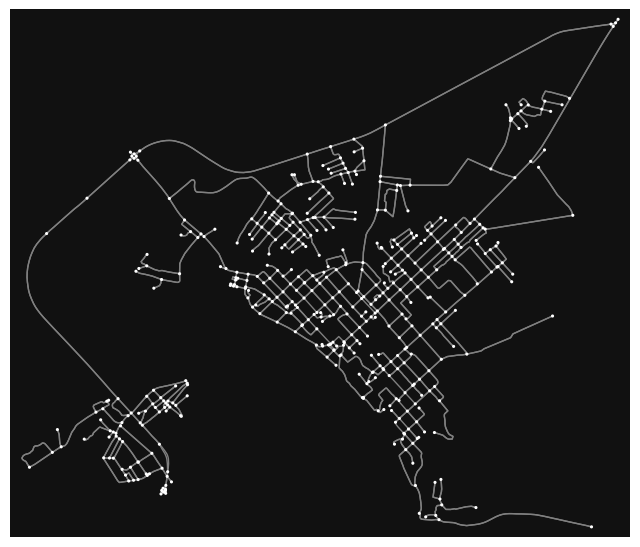

Центральность по степени:


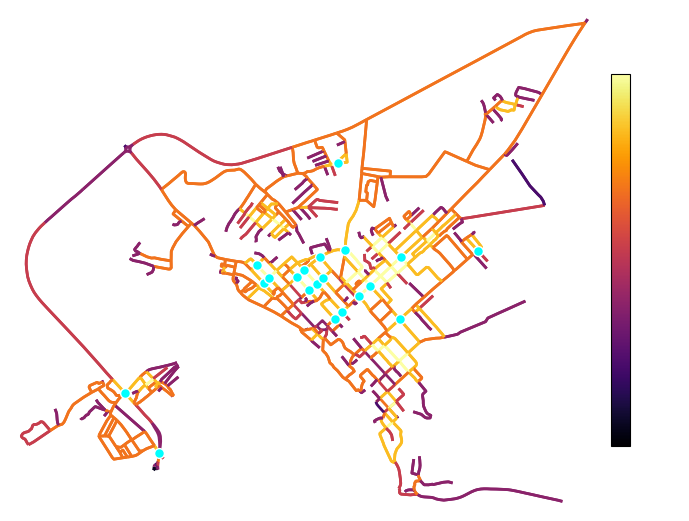

Центральность по близости:


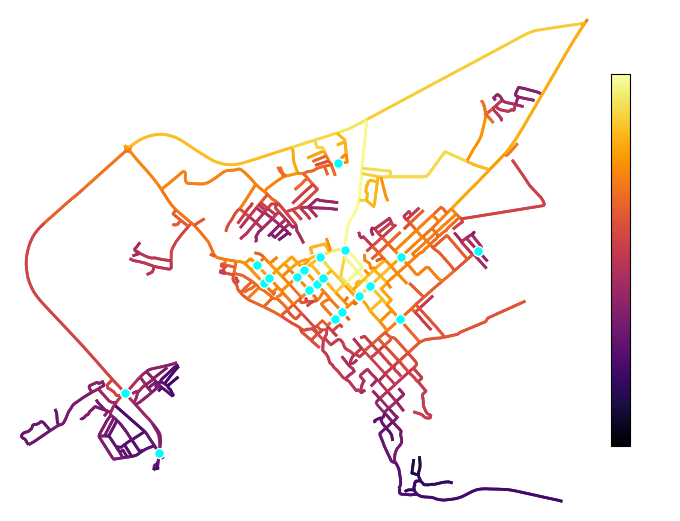


Метрики для вокзала:
Центральность по близости: 0.06835
Среднее время в пути: 6.3 мин
Макс. расстояние: 12.24 км (~18.4 мин)


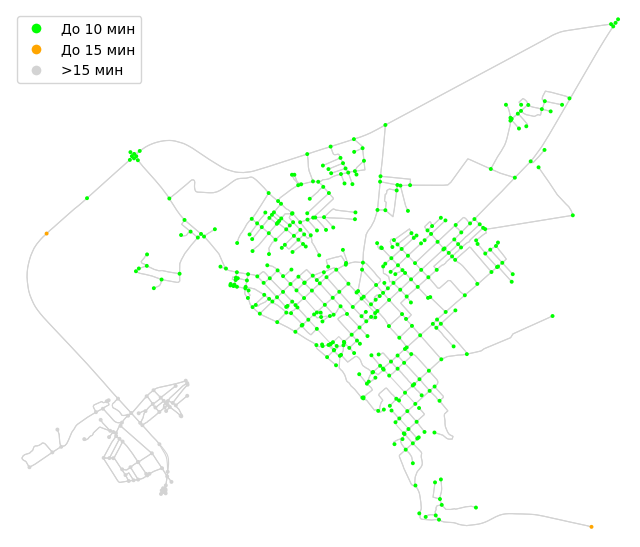

'degrees = [d for _, d in kasimov.graph.degree()]\nplt.hist(degrees, bins=20)\nplt.title("Распределение степеней узлов")\nplt.xlabel("Степень")\nplt.ylabel("Частота")\nplt.show()'

In [60]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
from matplotlib.lines import Line2D
from shapely.geometry import Point
from geopy.distance import geodesic
import os

save_dir = "kasimov_data"
os.makedirs(save_dir, exist_ok=True)

class CityStreetGraph:
    def __init__(self, city_name: str = None, network_type: str = "drive"):
        self.city_name = city_name
        self.network_type = network_type
        self.graph = None
        self.highlighted_nodes = set()

    def load_graph_by_place(self):
        if not self.city_name:
            raise ValueError("Название города не указано.")
        
        self.graph = ox.graph_from_place(self.city_name, network_type=self.network_type, simplify=True)

    def load_graph_by_point(self, lat: float, lon: float, distance: int = 3000):
        self.graph = ox.graph_from_point((lat, lon), dist=distance, network_type=self.network_type)

    def show_basic_info(self):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        
        stats = ox.basic_stats(self.graph)
        for k, v in stats.items():
            print(f"{k}: {v}")

    def draw_graph(self, save_path: str = None):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        
        fig, ax = ox.plot_graph(self.graph, node_size=5, edge_color='gray')
        # fig, ax = ox.plot_graph(self.graph, bgcolor="white", node_size=10, edge_color="#444444", edge_linewidth=0.8)
        if save_path:
            fig.savefig(save_path, dpi=300)
            print(f"Граф сохранён в файл: {save_path}")
        else:
            plt.show()

    def save_graphml(self, filename: str = "kasimov.graphml"):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")

        filepath = os.path.join(save_dir, filename)
        ox.save_graphml(self.graph, filepath)

    def load_graphml(self, filename: str = "kasimov.graphml"):
        filepath = os.path.join(save_dir, filename)
        self.graph = ox.load_graphml(filepath)

    def highlight_nodes_near_locations(self, locations: list[tuple[float, float, float]], remove_after=False):
        """
        Подсвечивает (и при необходимости удаляет) узлы, находящиеся в радиусе от заданных координат.
        :param locations: Список кортежей (lat, lon, radius_m)
        :param remove_after: Если True, узлы будут сразу удалены после подсветки
        """
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")

        self.highlighted_nodes.clear()

        for lat, lon, radius in locations:
            for node_id, data in self.graph.nodes(data=True):
                dist = geodesic((lat, lon), (data['y'], data['x'])).meters
                if dist <= radius:
                    self.highlighted_nodes.add(node_id)

        self.draw_graph_with_highlights()

        if remove_after:
            self.remove_highlighted_nodes()

    def remove_highlighted_nodes(self, save_filename: str = None):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")

        self.graph.remove_nodes_from(self.highlighted_nodes)
        self.highlighted_nodes.clear()

        if save_filename:
            filepath = os.path.join(save_dir, save_filename)
            ox.save_graphml(self.graph, filepath)

    def draw_graph_with_highlights(self):
        fig, ax = ox.plot_graph(self.graph, node_size=5, edge_color="gray", show=False, close=False)
        if self.highlighted_nodes:
            gdf_nodes = ox.graph_to_gdfs(self.graph, edges=False)
            highlighted = gdf_nodes.loc[list(self.highlighted_nodes)]
            ax.scatter(highlighted.geometry.x, highlighted.geometry.y, s=30, c='red', edgecolors='white', zorder=5)
        plt.show()

    def add_node(self, lat: float, lon: float):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")

        # Генерируем новый ID
        new_node_id = max(self.graph.nodes) + 1
        self.graph.add_node(new_node_id, x=lon, y=lat)

        # Находим ближайший узел
        nearest = ox.distance.nearest_nodes(self.graph, X=lon, Y=lat)
        # Соединяем в обе стороны
        distance = ox.distance.great_circle_vec(lat, lon, self.graph.nodes[nearest]['y'], self.graph.nodes[nearest]['x'])
        self.graph.add_edge(new_node_id, nearest, length=distance)
        self.graph.add_edge(nearest, new_node_id, length=distance)

        print(f"Добавлен узел {new_node_id}, соединён с узлом {nearest}.")

        fig, ax = ox.plot_graph(self.graph, node_size=5, edge_color="gray", show=False, close=False)
        ax.scatter(lon, lat, s=60, c='lime', edgecolors='black', zorder=5)
        plt.show()

    def find_centralities(self):
        line_G = nx.line_graph(self.graph)

        print("Центральность по степени:")
        edge_centrality = nx.degree_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        print("Центральность по близости:")
        edge_centrality = nx.closeness_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        """print("Центральность по посредничеству:")
        edge_centrality = nx.betweenness_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)"""

    def show_centrality_heatmap(self, edge_centrality, highlight_top_nodes=True):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        
        ev = []
        for edge in self.graph.edges(keys=False):
            edge_key = edge + (0,)
            val = edge_centrality.get(edge_key, 0)
            ev.append(val)
        
        norm = colors.Normalize(vmin=min(ev) * 0.8, vmax=max(ev))
        cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
        ec = [cmap.to_rgba(val) for val in ev]

        fig, ax = ox.plot_graph(
            self.graph,
            bgcolor='black',
            node_size=0,
            edge_color=ec,
            edge_linewidth=2,
            edge_alpha=1,
            show=False,
            close=False
        )

        if highlight_top_nodes:
            node_centrality = nx.degree_centrality(self.graph)
            top_nodes = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
            gdf_nodes = ox.graph_to_gdfs(self.graph, edges=False)
            for node_id, score in top_nodes:
                geom = gdf_nodes.loc[node_id].geometry
                ax.scatter(geom.x, geom.y, s=50, c='cyan', edgecolors='white', zorder=5)

        cbar = plt.colorbar(cmap, ax=ax, fraction=0.03, pad=0.02)
        #cbar.set_label("Центральность рёбер")
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

        #ax.set_title("Тепловая карта центральности рёбер", fontsize=12, color='white')
        ax.set_axis_off()
        plt.show()

    def analyze_station_metrics(self, station_coords, speed_kmh=40):
        print("\nМетрики для вокзала:")

        station_node = ox.distance.nearest_nodes(self.graph, X=station_coords[1], Y=station_coords[0])

        # Центральность по близости
        closeness = nx.closeness_centrality(self.graph)
        closeness_value = closeness[station_node]
        print(f"Центральность по близости: {closeness_value:.5f}")

        # Среднее время в пути
        lengths = nx.single_source_dijkstra_path_length(self.graph, station_node, weight="length")
        avg_distance_m = np.mean(list(lengths.values()))
        avg_time_min = avg_distance_m / (speed_kmh * 1000 / 60)
        print(f"Среднее время в пути: {avg_time_min:.1f} мин")

        # Доступность
        time_10_m = (10 / 60) * speed_kmh * 1000
        time_15_m = (15 / 60) * speed_kmh * 1000

        reachable_10 = [n for n, d in lengths.items() if d <= time_10_m]
        reachable_15 = [n for n, d in lengths.items() if d <= time_15_m]

        max_dist = max(lengths.values()) if lengths else 0
        print(f"Макс. расстояние: {max_dist/1000:.2f} км (~{max_dist/(speed_kmh * 1000 / 60):.1f} мин)")

        node_colors = []
        for node in self.graph.nodes:
            if node in reachable_10:
                node_colors.append("lime")
            elif node in reachable_15:
                node_colors.append("orange")
            else:
                node_colors.append("lightgray")

        fig, ax = ox.plot_graph(
            self.graph,
            node_color=node_colors,
            node_size=8,
            edge_color="lightgray",
            edge_linewidth=0.8,
            bgcolor="white",
            show=False,
            close=False
        )

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='До 10 мин', markerfacecolor='lime', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='До 15 мин', markerfacecolor='orange', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='>15 мин', markerfacecolor='lightgray', markersize=8),
        ]
        ax.legend(handles=legend_elements, loc='upper left')
        # ax.set_title("Транспортная доступность вокзала", fontsize=12)
        ax.set_axis_off()
        plt.show()


kasimov = CityStreetGraph(network_type="drive")

"""latitude = 54.937289
longitude = 41.391369
kasimov.load_graph_by_point(lat=latitude, lon=longitude, distance=4500)

kasimov.show_basic_info()
kasimov.draw_graph()
regions = [
    (54.906673, 41.334081, 1000),
    (54.956080, 41.325784, 590),
    (54.949464, 41.330700, 100),
    (54.977284, 41.323257, 1000),
    (54.973779, 41.395870, 500),
    (54.907629, 41.420843, 800),
    (54.899666, 41.448738, 200),
    (54.917667, 41.457063, 500)
]
kasimov.highlight_nodes_near_locations(regions, remove_after=True)
kasimov.remove_highlighted_nodes(save_filename="kasimov_cleaned.graphml")"""
kasimov.load_graphml("kasimov_cleaned.graphml")
kasimov.show_basic_info()
kasimov.draw_graph()
kasimov.find_centralities()
kasimov.analyze_station_metrics(station_coords=(54.946817, 41.409804))

"""degrees = [d for _, d in kasimov.graph.degree()]
plt.hist(degrees, bins=20)
plt.title("Распределение степеней узлов")
plt.xlabel("Степень")
plt.ylabel("Частота")
plt.show()"""

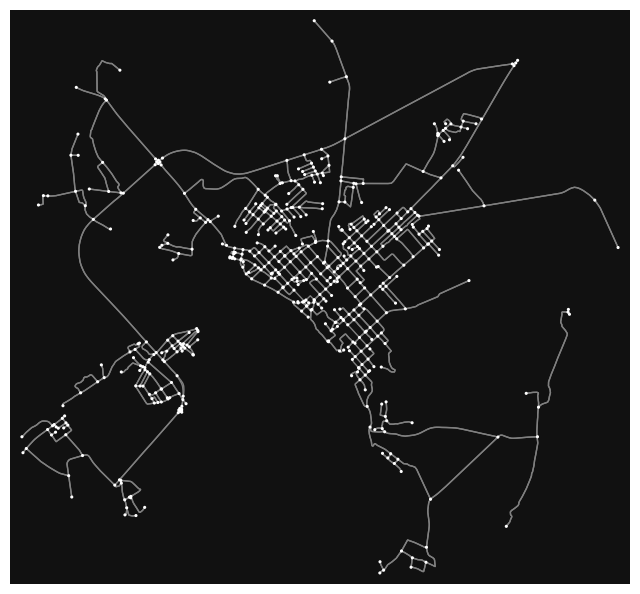

Центральность по степени:


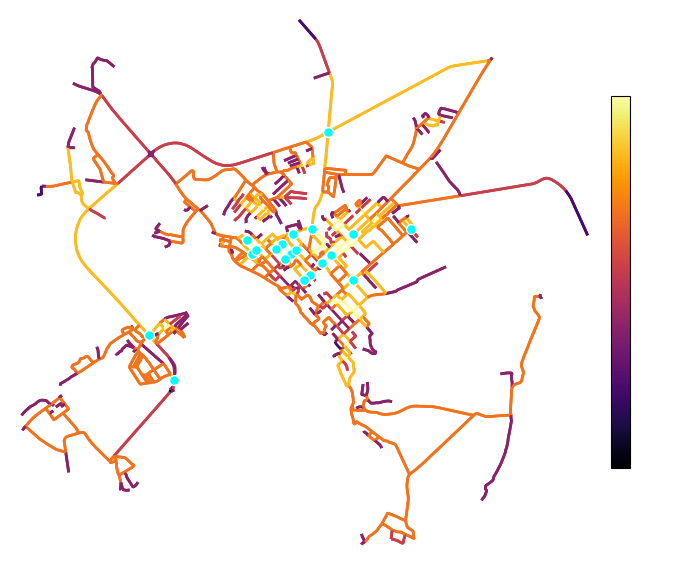

Центральность по близости:


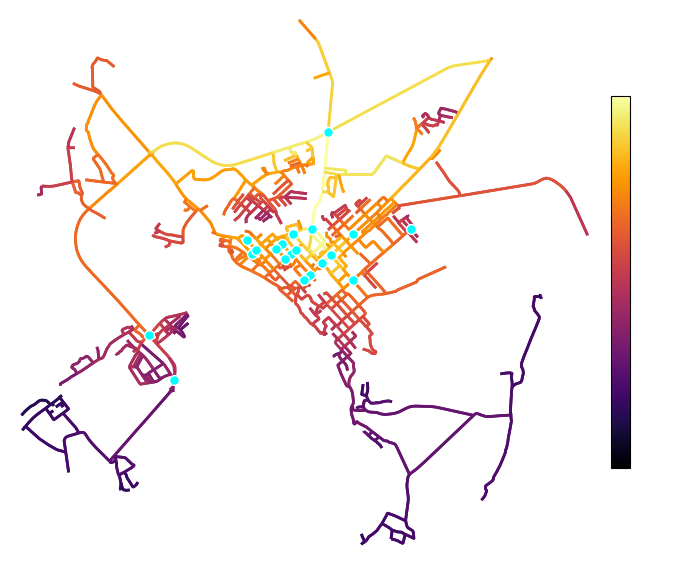


Поиск транспортных проблем:


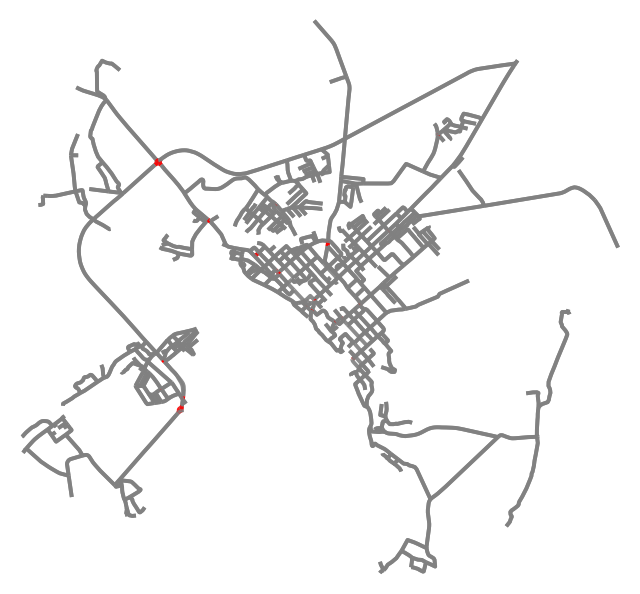

Топ проблемных участков:
1. Без названия (1325512694 → 624687158) | Score: 0.0027 | Betweenness: 0.06059 | Длина: 7.3 м | Мин. степень: 3
2. Без названия (3396516148 → 6989087858) | Score: 0.0016 | Betweenness: 0.05833 | Длина: 6.0 м | Мин. степень: 6
3. Без названия (3396497601 → 1420752983) | Score: 0.0009 | Betweenness: 0.06134 | Длина: 11.0 м | Мин. степень: 6
4. Без названия (1420752983 → 3396497601) | Score: 0.0009 | Betweenness: 0.05956 | Длина: 11.0 м | Мин. степень: 6
5. Октябрьская улица (670340299 → 3388972997) | Score: 0.0009 | Betweenness: 0.06412 | Длина: 14.2 м | Мин. степень: 5
6. Без названия (602647232 → 602647218) | Score: 0.0009 | Betweenness: 0.17827 | Длина: 49.8 м | Мин. степень: 4
7. улица Рязанский Спуск (602494990 → 602495002) | Score: 0.0008 | Betweenness: 0.06995 | Длина: 16.8 м | Мин. степень: 5
8. Без названия (602647230 → 602647232) | Score: 0.0008 | Betweenness: 0.15734 | Длина: 48.8 м | Мин. степень: 4
9. Без названия (624687158 → 602736172) | Score: 0.

In [61]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import pandas as pd
from shapely.geometry import Point
import numpy as np


class TransportNetworkModel:
    def __init__(self, place_name: str, buffer_dist: int = 2000, network_type="drive"):
        self.place_name = place_name
        self.buffer_dist = buffer_dist
        self.network_type = network_type
        self.graph = None

    def download_graph(self):
        gdf = ox.geocode_to_gdf(self.place_name)
        polygon = gdf.geometry.values[0]
        polygon_utm, crs_utm = ox.projection.project_geometry(polygon)
        buffered_utm = polygon_utm.buffer(self.buffer_dist)
        buffered_latlon, _ = ox.projection.project_geometry(buffered_utm, crs=crs_utm, to_latlong=True)
        self.graph = ox.graph_from_polygon(buffered_latlon, network_type=self.network_type)

    def show_graph(self):
        ox.plot_graph(self.graph, node_size=5, edge_color='gray')

    def find_centralities(self):
        line_G = nx.line_graph(self.graph)

        print("Центральность по степени:")
        edge_centrality = nx.degree_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        """print("Центральность по собственному вектору:")
        edge_centrality = nx.eigenvector_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)"""

        print("Центральность по близости:")
        edge_centrality = nx.closeness_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        # print("Центральность по посредничеству:")
        # edge_centrality = nx.betweenness_centrality(line_G)
        # self.show_centrality_heatmap(edge_centrality)

    def show_centrality_heatmap(self, edge_centrality, highlight_top_nodes=True):
        ev = []
        for edge in self.graph.edges(keys=False):
            edge_key = edge + (0,)
            val = edge_centrality.get(edge_key, 0)
            ev.append(val)

        norm = colors.Normalize(vmin=min(ev) * 0.8, vmax=max(ev))
        cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
        ec = [cmap.to_rgba(val) for val in ev]

        fig, ax = ox.plot_graph(
            self.graph,
            bgcolor='black',
            node_size=0,
            edge_color=ec,
            edge_linewidth=2,
            edge_alpha=1,
            show=False,
            close=False
        )

        if highlight_top_nodes:
            node_centrality = nx.degree_centrality(self.graph)
            top_nodes = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
            gdf_nodes = ox.graph_to_gdfs(self.graph, edges=False)
            for node_id, score in top_nodes:
                geom = gdf_nodes.loc[node_id].geometry
                ax.scatter(geom.x, geom.y, s=50, c='cyan', edgecolors='white', zorder=5)

        cbar = plt.colorbar(cmap, ax=ax, fraction=0.03, pad=0.02)
        #cbar.set_label("Центральность рёбер")
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

        #ax.set_title("Тепловая карта центральности рёбер", fontsize=12, color='white')
        ax.set_axis_off()
        plt.show()

    def find_bottlenecks(self, top_k=50):
        """
        Поиск проблемных участков:
        - Высокая междуцентральность (узкие горлышки)
        - Малая степень у узлов (мало обходных путей)
        - Маленькая длина (мосты, переезды)
        """
        print("\nПоиск транспортных проблем:")

        simple_graph = nx.DiGraph()
        for u, v, data in self.graph.edges(data=True):
            length = data.get("length", 1)
            if simple_graph.has_edge(u, v):
                simple_graph[u][v]["length"] = min(simple_graph[u][v]["length"], length)
            else:
                simple_graph.add_edge(u, v, length=length)

        edge_betweenness = nx.edge_betweenness_centrality(simple_graph, weight="length")

        edge_scores = []

        for u, v, k in self.graph.edges(keys=True):
            edge = (u, v, k)

            btwn = edge_betweenness.get((u, v), 0) or edge_betweenness.get((v, u), 0)

            length = self.graph[u][v][k].get("length", 1)
            deg_u = self.graph.degree(u)
            deg_v = self.graph.degree(v)
            min_deg = min(deg_u, deg_v)

            score = (btwn / length) * (1 / (min_deg + 0.1))
            edge_scores.append((edge, score, btwn, length, min_deg))

        edge_scores.sort(key=lambda x: x[1], reverse=True)
        worst_edges = [edge for edge, *_ in edge_scores[:top_k]]

        edge_colors = []
        for edge in self.graph.edges(keys=True):
            if edge in worst_edges:
                edge_colors.append("red")
            else:
                edge_colors.append("gray")

        fig, ax = ox.plot_graph(
            self.graph,
            edge_color=edge_colors,
            edge_linewidth=2.8,
            node_size=0,
            edge_alpha=0.9,
            bgcolor="white",
            show=False,
            close=False
        )
        plt.show()

        print("Топ проблемных участков:")
        for i, (edge, score, btwn, length, min_deg) in enumerate(edge_scores[:top_k]):
            u, v, k = edge
            street_name = self.graph[u][v][k].get("name", "Без названия")
            print(
                f"{i+1}. {street_name} ({u} → {v}) | Score: {score:.4f} | "
                f"Betweenness: {btwn:.5f} | Длина: {length:.1f} м | Мин. степень: {min_deg}"
            )


model = TransportNetworkModel(place_name="Касимов, Рязанская область, Россия", buffer_dist=2500)
model.download_graph()
model.show_graph()
model.find_centralities()
model.find_bottlenecks()
# nodes = sorted(list(nx.closeness_centrality(model.graph).items()), key=lambda i: i[1], reverse=True)
# print(*nodes[:10], sep='\n')